### Import packages

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import avro
import avro.schema
from avro.datafile import DataFileReader
from avro.io import DatumReader
import pandas as pd
from datetime import datetime
import pytz
import neurokit2 as nk

### Define paths

In [3]:
file_ref = pd.read_excel('/Users/dhwanishah/Desktop/MS/VR-Dhwani/avros-to-analyze.xlsx')
input_dir = '/Users/dhwanishah/Desktop/MS/VR-Dhwani/subject-avros'
output_dir = '/Users/dhwanishah/Desktop/MS/VR-Dhwani/subject-csvs-eda-new'

### Define functions

In [4]:
def extract_eda_from_avro(file_path):
    with open(file_path, 'rb') as avro_file:
        reader = DataFileReader(avro_file, DatumReader())
        record = next(reader)
        rawData = record.get('rawData', None)
        eda = rawData.get('eda', None)
        bvp = rawData.get('bvp', None)
        systolicPeaks = rawData.get('systolicPeaks', None)
    return eda, bvp, systolicPeaks

In [5]:
def convert_est_edt_to_utc(eastern_time):
    eastern = pytz.timezone('America/New_York')
    eastern_time = eastern.localize(eastern_time)
    utc_time = eastern_time.astimezone(pytz.utc)
    return utc_time

### Process data

In [9]:
for index, row in file_ref.iterrows():
    input_path = (os.path.join(input_dir, row['SubID'], row['FileName-1']))
    output_path = f"{output_dir}/{row['SubID']}/session-{row['Session']}"
    
    start_time = convert_est_edt_to_utc(row['Start']).replace(tzinfo=None)
    start_time = pd.to_datetime(start_time, unit='s', utc=True)
    
    end_time = convert_est_edt_to_utc(row['End']).replace(tzinfo=None)
    end_time = pd.to_datetime(end_time, unit='s', utc=True)
    
    eda_data, bvp_data, systolicPeaks_data = extract_eda_from_avro(input_path)
    values = eda_data['values']
    timestamp_start = eda_data['timestampStart'] 
    sampling_frequency = eda_data['samplingFrequency']
    # print(f"sampling frequency:{sampling_frequency}")
    
    # If eda data is split into 2 files, load in the values from file2
    if isinstance(row['FileName-2'], str):
        input_path2 = (os.path.join(input_dir, row['SubID'], row['FileName-2']))
        eda_data2, bvp_data2, systolicPeaks_data2 = extract_eda_from_avro(input_path2)
        # eda_data2 = extract_eda_from_avro(input_path2)
        values2 = eda_data2['values']
        values.extend(values2)
    
    # Smooth eda values
    # values_smoothed = nk.signal_smooth(values, method = 'convolution', kernel = 'boxcar', size=3)
    
    # Convert timestamp_start from microseconds to seconds
    timestamp_start_seconds = timestamp_start / 1_000_000
    
    # Generate a list of timestamps
    time_seconds = list(range(len(values)))
    timestamps = [timestamp_start_seconds + t / sampling_frequency for t in time_seconds]
    
    # Convert timestamps to datetime objects
    datetime_objects = pd.to_datetime(timestamps, unit='s', utc=True)
    
    # Create a DataFrame with timestamps, raw, EDA values, and smoothed EDA values
    # df = pd.DataFrame({'timestamp': datetime_objects,
    #                    'eda_raw': values, 
    #                    'eda_smoothed': values_smoothed})
    
    # Trim the DataFrame based on start and end time points of the experimental session
    df = pd.DataFrame({'Values': values, 'Timestamp': datetime_objects})
    df = df[(df['Timestamp'] >= start_time) & (df['Timestamp'] <= end_time)].reset_index(drop=True)
    
    # Update BVP values and timestamps after trimming
    values = df['Values']
    datetime_objects_trimmed = df['Timestamp']

    # Process the smoothed eda signal; add processed signals to DataFrame 
    # signals, info = nk.eda_process(df['eda_smoothed'], sampling_rate=4)
    signals, info = nk.eda_process(values, sampling_rate=sampling_frequency)
    df = pd.concat([df, signals], axis=1)
    
    # # Save the DataFrame as a csv
    # os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Create directories if they don’t exist

    # df.to_csv(f"{output_path}.csv", index=False)

In [23]:
print(df)
.replace(tzinfo=None)

        Values                           Timestamp   EDA_Raw  EDA_Clean  \
0     0.098527 2024-05-17 16:27:37.192368031+00:00  0.098527   0.098527   
1     0.098426 2024-05-17 16:27:37.442351818+00:00  0.098426   0.098426   
2     0.098109 2024-05-17 16:27:37.692335606+00:00  0.098109   0.098109   
3     0.097432 2024-05-17 16:27:37.942319393+00:00  0.097432   0.097432   
4     0.098354 2024-05-17 16:27:38.192303181+00:00  0.098354   0.098354   
...        ...                                 ...       ...        ...   
1863  0.077931 2024-05-17 16:35:22.912110806+00:00  0.077931   0.077931   
1864  0.078809 2024-05-17 16:35:23.162094355+00:00  0.078809   0.078809   
1865  0.078982 2024-05-17 16:35:23.412078142+00:00  0.078982   0.078982   
1866  0.079212 2024-05-17 16:35:23.662061930+00:00  0.079212   0.079212   
1867  0.079299 2024-05-17 16:35:23.912045717+00:00  0.079299   0.079299   

      EDA_Tonic  EDA_Phasic  SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  \
0      0.098774   

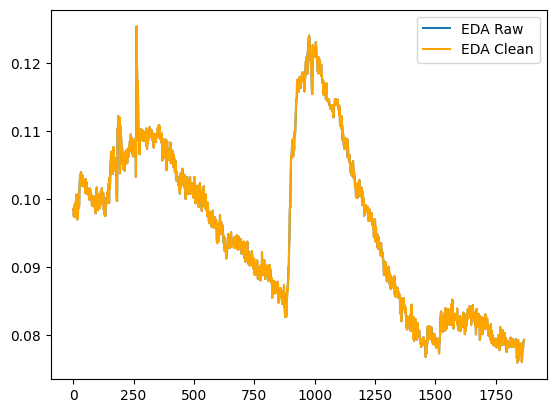

In [19]:
plt.plot(signals['EDA_Raw'], label='EDA Raw')
plt.plot(signals['EDA_Clean'], label='EDA Clean', color='orange')
plt.legend()
plt.show()

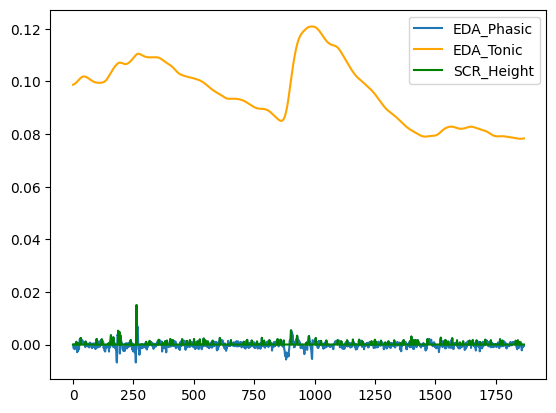

0.09578504004769146

In [20]:
plt.plot(signals['EDA_Phasic'], label='EDA_Phasic')
plt.plot(signals['EDA_Tonic'], label='EDA_Tonic', color='orange')
plt.plot(signals['SCR_Height'], label='SCR_Height', color='green')
plt.legend()
plt.show()

signals['EDA_Phasic'].mean()
signals['SCR_Height'].mean()
signals['EDA_Tonic'].mean()

In [33]:
for index, row in file_ref.iterrows():
    input_path = (os.path.join(input_dir, row['SubID'], row['FileName-1']))
    output_path = f"{output_dir}/{row['SubID']}/session-{row['Session']}"
    
    # input_path = "/Users/dhwanishah/Desktop/MS/VR-Dhwani/subject-avros/sub-11/1-1-VRTL11S5_1715967028.avro"
    # hr_output_path = "/Users/dhwanishah/Desktop/MS/VR-Dhwani/rapidhrv-avro-to-csvs"


    start_time = convert_est_edt_to_utc(row['Start']).replace(tzinfo=None)
    start_time = pd.to_datetime(start_time, unit='s', utc=True)
    
    end_time = convert_est_edt_to_utc(row['End']).replace(tzinfo=None)
    end_time = pd.to_datetime(end_time, unit='s', utc=True)
    
    eda_data, bvp_data, systolicPeaks_data = extract_eda_from_avro(input_path)
    values = eda_data['values']
    timestamp_start = eda_data['timestampStart'] 
    sampling_frequency = eda_data['samplingFrequency']
    # print(f"sampling frequency:{sampling_frequency}")
    
    # If eda data is split into 2 files, load in the values from file2
    if isinstance(row['FileName-2'], str):
        input_path2 = (os.path.join(input_dir, row['SubID'], row['FileName-2']))
        eda_data2, bvp_data2, systolicPeaks_data2 = extract_eda_from_avro(input_path2)
        # eda_data2 = extract_eda_from_avro(input_path2)
        values2 = eda_data2['values']
        values.extend(values2)
    
    # Smooth eda values
    # values_smoothed = nk.signal_smooth(values, method = 'convolution', kernel = 'boxcar', size=3)
    
    # Convert timestamp_start from microseconds to seconds
    timestamp_start_seconds = timestamp_start / 1_000_000
    
    # Generate a list of timestamps
    time_seconds = list(range(len(values)))
    timestamps = [timestamp_start_seconds + t / sampling_frequency for t in time_seconds]
    
    # Convert timestamps to datetime objects
    datetime_objects = pd.to_datetime(timestamps, unit='s', utc=True)
    
    # Create a DataFrame with timestamps, raw, EDA values, and smoothed EDA values
    # df = pd.DataFrame({'timestamp': datetime_objects,
    #                    'eda_raw': values, 
    #                    'eda_smoothed': values_smoothed})
    
    # Trim the DataFrame based on start and end time points of the experimental session
    df = pd.DataFrame({'Values': values, 'Timestamp': datetime_objects})
    df = df[(df['Timestamp'] >= start_time) & (df['Timestamp'] <= end_time)].reset_index(drop=True)
    
    # Update BVP values and timestamps after trimming
    values = df['Values']
    datetime_objects_trimmed = df['Timestamp']

    # Process the smoothed eda signal; add processed signals to DataFrame 
    # signals, info = nk.eda_process(df['eda_smoothed'], sampling_rate=4)
    eda_clean = nk.eda_clean(values, sampling_rate=sampling_frequency, method='neurokit')
    signals, info = nk.eda_process(eda_clean, sampling_rate=sampling_frequency)
    df = pd.concat([df, signals], axis=1)
    
    # # Save the DataFrame as a csv
    # os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Create directories if they don’t exist

    # df.to_csv(f"{output_path}.csv", index=False)

        Values                           Timestamp   EDA_Raw  EDA_Clean  \
0     0.098527 2024-05-17 16:27:37.192368031+00:00  0.098527   0.098527   
1     0.098426 2024-05-17 16:27:37.442351818+00:00  0.098426   0.098426   
2     0.098109 2024-05-17 16:27:37.692335606+00:00  0.098109   0.098109   
3     0.097432 2024-05-17 16:27:37.942319393+00:00  0.097432   0.097432   
4     0.098354 2024-05-17 16:27:38.192303181+00:00  0.098354   0.098354   
...        ...                                 ...       ...        ...   
1863  0.077931 2024-05-17 16:35:22.912110806+00:00  0.077931   0.077931   
1864  0.078809 2024-05-17 16:35:23.162094355+00:00  0.078809   0.078809   
1865  0.078982 2024-05-17 16:35:23.412078142+00:00  0.078982   0.078982   
1866  0.079212 2024-05-17 16:35:23.662061930+00:00  0.079212   0.079212   
1867  0.079299 2024-05-17 16:35:23.912045717+00:00  0.079299   0.079299   

      EDA_Tonic  EDA_Phasic  SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  \
0      0.098774   

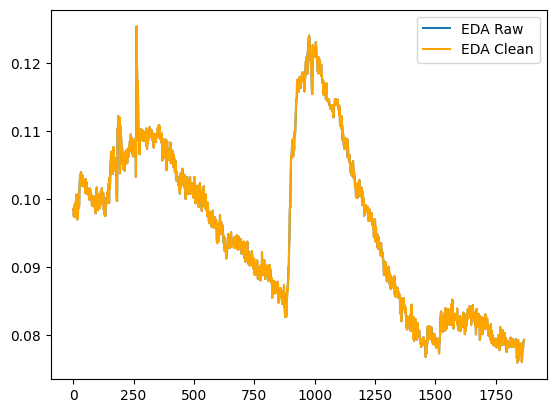

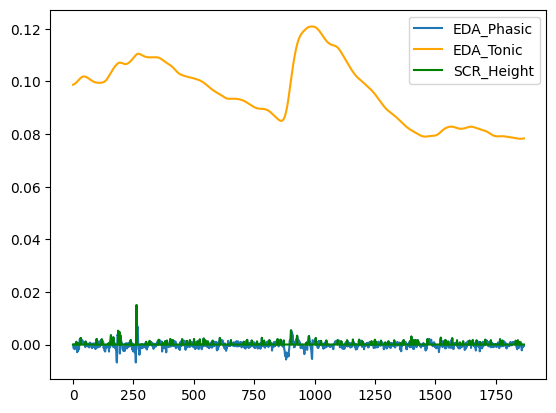

0.09578504004769146

In [34]:
print(df)
plt.plot(signals['EDA_Raw'], label='EDA Raw')
plt.plot(signals['EDA_Clean'], label='EDA Clean', color='orange')
plt.legend()
plt.show()


plt.plot(signals['EDA_Phasic'], label='EDA_Phasic')
plt.plot(signals['EDA_Tonic'], label='EDA_Tonic', color='orange')
plt.plot(signals['SCR_Height'], label='SCR_Height', color='green')
plt.legend()
plt.show()

signals['EDA_Phasic'].mean()
signals['SCR_Height'].mean()
signals['EDA_Tonic'].mean()

[0.01906252 0.01910573 0.0189473  ... 0.02735866 0.02722903 0.02872695]
       EDA_Raw  EDA_Clean  EDA_Tonic    EDA_Phasic  SCR_Onsets  SCR_Peaks  \
0     0.019063   0.019063   0.019063 -3.164053e-07           0          0   
1     0.019106   0.019106   0.019052  5.387360e-05           0          0   
2     0.018947   0.018947   0.019041 -9.333286e-05           0          0   
3     0.018947   0.018947   0.019029 -8.189000e-05           0          0   
4     0.018947   0.018947   0.019018 -7.026414e-05           0          0   
...        ...        ...        ...           ...         ...        ...   
1867  0.029678   0.029678   0.028001  1.175339e-03           0          1   
1868  0.029217   0.029217   0.028018  6.080179e-04           0          0   
1869  0.027359   0.027359   0.028032 -1.361420e-03           0          0   
1870  0.027229   0.027229   0.028045 -1.607681e-03           0          0   
1871  0.028727   0.028727   0.028056 -2.317218e-04           0          0   

   

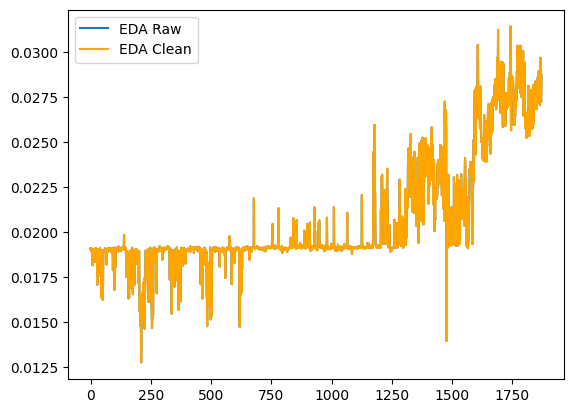

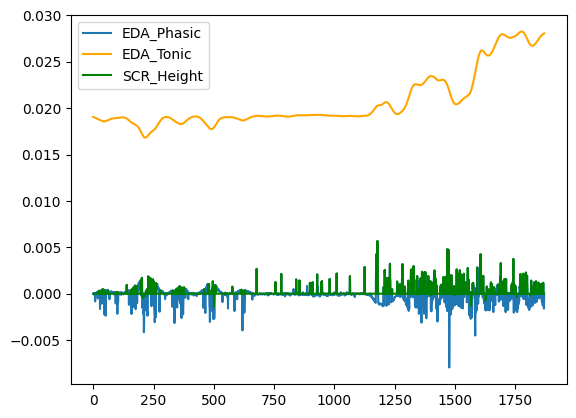

0.020689115085375565

In [7]:
data = pd.read_csv('/Users/dhwanishah/Desktop/MS/VR-Dhwani/subject-csvs-eda-new/sub-4/session-5a.csv')
eda_cleaned = nk.eda_clean(data['EDA_Raw'], sampling_rate=4)
signals, info = nk.eda_process(eda_cleaned, sampling_rate=4, method_quality='disimilarity')

print(eda_cleaned)
print(signals)
plt.plot(signals['EDA_Raw'], label='EDA Raw')
plt.plot(signals['EDA_Clean'], label='EDA Clean', color='orange')
plt.legend()
plt.show()


plt.plot(signals['EDA_Phasic'], label='EDA_Phasic')
plt.plot(signals['EDA_Tonic'], label='EDA_Tonic', color='orange')
plt.plot(signals['SCR_Height'], label='SCR_Height', color='green')
plt.legend()
plt.show()

signals['EDA_Phasic'].mean()
signals['SCR_Height'].mean()
signals['EDA_Tonic'].mean()